In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sp_inference import processes, model, logging
from sp_inference.postprocessing import visualization as viz, data_types as dt

In [2]:
logSettings = {
    "output_directory":           "01_example_single_parameter",
    "verbose":                    True
}

dataSettings = {
    "process_type":               "OUProcess",
    "drift_parameters":           1,
    "diffusion_parameters":       1,
    "standard_deviation":         0.02,
    "rng_seed":                   0,
    "num_points":                 50,
    "domain_bounds":              [-1, 1]
}

modelSettings = {
    "params_to_infer":            "drift",
    "model_type":                 "mean_exit_time",
    "is_stationary":              True
}

priorSettings = {
    "mean_function":              "-0.1*x",
    "variance":                   "0.01 + 0.1*x**2",
    "correlation_length":         0.5,
    "robin_bc":                   True,
    "robin_bc_const":             5
}

feSettings = {
    "num_mesh_points":            500,
    "boundary_locations":         [-1, 1],
    "boundary_values":            [0, 0],
    "element_degrees":            [1, 1],
    "squared_diffusion_function": 1
}

solverSettings = {
    "rel_tolerance":              1e-6,
    "abs_tolerance":              1e-12,
    "max_iter":                   50,
    "GN_iter":                    5,
    "c_armijo":                   1e-4,
    "max_backtracking_iter":      10
}

hessianSettings = {
    "num_eigvals":                20,
    "num_oversampling":           5
}

In [3]:
try:
    os.system('rm -r ' + logSettings["output_directory"])
except:
    pass

logger = logging.Logger(logSettings["verbose"],
                        logSettings["output_directory"])

In [4]:
randGenerator = np.random.default_rng(dataSettings["rng_seed"])
randLocs = randGenerator.uniform(*dataSettings["domain_bounds"], dataSettings["num_points"])
dataSettings["domain_points"] = randLocs

processType = processes.get_process(dataSettings["process_type"])
process = processType(dataSettings["drift_parameters"],
                      dataSettings["diffusion_parameters"],
                      logger)

forwardNoisy, forwardExact = process.generate_data(modelSettings["model_type"],
                                                   modelSettings["is_stationary"],
                                                   dataSettings)

exactDrift = process.compute_drift(randLocs)

misFitSettings = {
    "data_locations": randLocs,
    "data_values": forwardNoisy,
    "data_var": dataSettings["standard_deviation"]**2
}

===================== Invoke OUProcess =====================
 
Drift Coefficient(s): 1 
Diffusion Coefficient(s): 1 

Generate MET data:                 Successful 



In [5]:
inferenceModel = model.SDEInferenceModel(modelSettings,
                                         priorSettings,
                                         feSettings,
                                         misFitSettings,
                                         logger=logger)

priorMeanData, priorVarianceData, priorForwardData = inferenceModel.get_prior_info("Randomized")
mapMeanData, mapVarianceData, mapForwardData, hessEigVals \
    = inferenceModel.compute_gr_posterior(solverSettings, hessianSettings)

================== Invoke Inference Model ==================
 
Construct PDE Problem:             Successful 

Construct Prior:                   Successful 

Construct Misfit:                  Successful 

 
=============== Conduct Linearized Inference ===============
 
Solve for MAP: 

It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.518108e+03    1.500965e+03    1.714342e+01   -1.539259e+04   1.927441e+04   1.000000e+00   5.000000e-01
  2   1    5.069276e+01    4.019681e+01    1.049595e+01   -2.950631e+03   1.664042e+04   1.000000e+00   5.000000e-01
  3   2    2.855988e+01    1.848599e+01    1.007389e+01   -4.428489e+01   1.125578e+03   1.000000e+00   2.416557e-01
  4   5    2.825041e+01    1.802712e+01    1.022330e+01   -6.177333e-01   3.663663e+01   1.000000e+00   4.359806e-02
  5   5    2.825020e+01    1.802768e+01    1.022252e+01   -4.250350e-04   2.630178e+00   1.000000e+00   1.168159e-02
  6   8

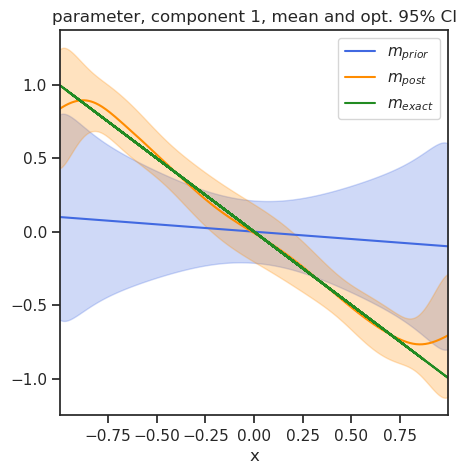

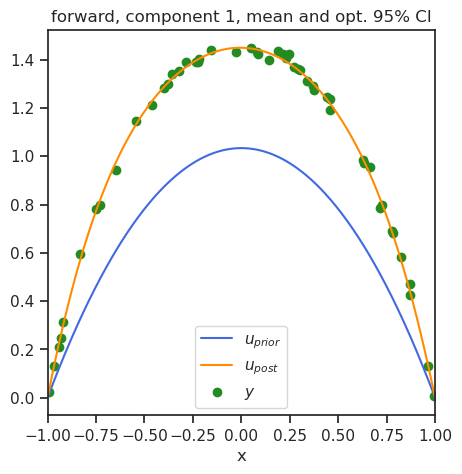

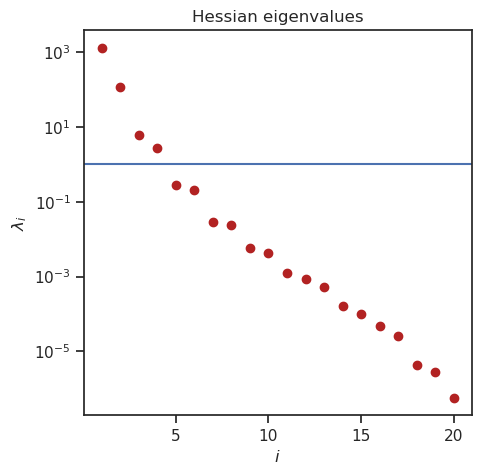

In [6]:
parameter_domain = dt.Grid1D(priorMeanData[0])
forward_domain = dt.Grid1D(priorForwardData[0])
data_domain = dt.Grid1D(randLocs)

prior_mean_component = dt.StationaryFieldComponent(parameter_domain, priorMeanData[1])
prior_var_component = dt.StationaryFieldComponent(parameter_domain, priorVarianceData[1])
prior_forward_component = dt.StationaryFieldComponent(forward_domain, priorForwardData[1])
map_mean_component = dt.StationaryFieldComponent(parameter_domain, mapMeanData[1])
map_var_component = dt.StationaryFieldComponent(parameter_domain, mapVarianceData[1])
map_forward_component = dt.StationaryFieldComponent(forward_domain, mapForwardData[1])
exact_param_component = dt.StationaryFieldComponent(data_domain, exactDrift)
data_component = dt.StationaryFieldComponent(data_domain, forwardNoisy)

prior_mean_field = dt.StationaryField(prior_mean_component)
prior_var_field = dt.StationaryField(prior_var_component)
prior_forward_field = dt.StationaryField(prior_forward_component)
map_mean_field = dt.StationaryField(map_mean_component)
map_var_field = dt.StationaryField(map_var_component)
map_forward_field = dt.StationaryField(map_forward_component)
exact_param_field = dt.StationaryField(exact_param_component)
data_field = dt.StationaryField(data_component)

prior_param_data = dt.InferenceData(label=r'$m_{prior}$',
                                    field=prior_mean_field,
                                    variance_field=prior_var_field)
posterior_param_data = dt.InferenceData(label=r'$m_{post}$',
                                        field=map_mean_field,
                                        variance_field=map_var_field)
exact_param_data = dt.InferenceData(label=r'$m_{exact}$',
                                    field=exact_param_field)
prior_forward_data = dt.InferenceData(label=r'$u_{prior}$',
                                      field=prior_forward_field)
posterior_forward_data = dt.InferenceData(label=r'$u_{post}$',
                                          field=map_forward_field)
point_data = dt.InferenceData(label=r'$y$',
                              field=data_field,
                              is_point_data=True)

plt.close('all')
results_dir = os.path.join(logSettings["output_directory"], "visualization")
os.makedirs(results_dir, exist_ok=True)
visualizer = viz.Visualizer()
visualizer.plot_inference_data(prior_param_data,
                               posterior_param_data,
                               exact_param_data,
                               path_name=os.path.join(results_dir,"parameter"))
visualizer.plot_inference_data(prior_forward_data,
                               posterior_forward_data,
                               point_data,
                               path_name=os.path.join(results_dir,"forward"))
viz.plot_hessian_data(hessEigVals, path_name=results_dir)